# Final Project - TRON Tournament

## 1. Set-up

In [1]:
# Import any libraries you might need to develop our agent.
import numpy as np
import matplotlib
import time
import signal
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML, clear_output

## 2. Agent

The task is to implement an agent using a technique discussed during the class. Your agent should be able to beat random player ~99% of the time, and must comply with a  time limit of 5 seconds per move. Furthermore, you cannot modify the game board directly; any projects that do so that will be disqualified.

In [2]:
# TODO: Implement your agent here.
class PlayerAgent:
    import copy
    def __init__(self, player_id):
        self.player_id = player_id

    def choose_move(self, game):
        # Get an array of legal moves from your current position.
        legal_moves = game.get_legal_moves(self.player_id)
        # print(len(legal_moves))
        legal_moves_copy = copy.deepcopy(legal_moves)
        # Generate score dictionary
        score_dic = {}
        for each in legal_moves:
            score_dic[str(each)] = 0

        next_moves = []

        score = self.alpha_beta(1, float("-inf"), float("inf"), 20, legal_moves_copy,score_dic)
        # print(score_dic)
        for each_move in legal_moves:
            if score_dic[str(each_move)] == score:
                # print("choose")
                next_moves.append(each_move)
        return next_moves[0]
        # Choose an action to take based on the algorithm you
        # decide to implement. This method should return
        # one of the items in the 'legal_moves' array.

    def alpha_beta(self, current_agent, alpha, beta, depth, legal_moves,score_dic):
        """
        :param current_agent: 1:self, 0:opponent
        :param alpha:
        :param beta:
        :param depth:
        :param legal_moves:
        """
        if self.check_situation(legal_moves):  # no place to go
            if current_agent == 1:  # I lose the game
                return float("-inf")
            else:  # I win the game
                return float("inf")
        if depth == 0:  # return to root node
            return self.compute_score()  # calculate the score for next move
        if current_agent == 1:  # It is my turn
            for each_move in legal_moves:  # for each child
                # create next move
                legal_moves.remove(each_move)
                # print("length of legal_moves:", len(legal_moves))
                value = self.alpha_beta(0, alpha, beta, depth - 1, legal_moves,score_dic)
                if value > alpha:
                    alpha = value
                    score_dic[str(each_move)]=alpha
                if alpha >= beta:
                    break
            return alpha
        elif current_agent == 0:  # It is not my turn
            for each_move in legal_moves:
                legal_moves.remove(each_move)
                # print("length of legal_moves:", len(legal_moves))
                value = self.alpha_beta(0, alpha, beta, depth - 1, legal_moves,score_dic)
                if value < beta:
                    beta = value
                    score_dic[str(each_move)]=beta
                if alpha >= beta:
                    break
            return beta

    def check_situation(self, legal_moves):
        # Return true if there is no place to go
        return len(legal_moves) == 0

    def compute_score(self):
        return np.random.rand()

    def get_best_move(self, legal_moves):
        value = self.compute_score()

    def compute_score(self):
        return 0

    


# This is an example of an agent which simply picks a move at random.
class RandomAgent:
    def __init__(self, player_id):
        self.player_id = player_id

    def choose_move(self, game):
        # Get an array of legal moves from your current position.
        legal_moves = game.get_legal_moves(self.player_id)

        # Shuffle the legal moves and pick the first one. This is equivalent
        # to choosing a move randomly with no logic.
        np.random.shuffle(legal_moves)
        return legal_moves[0]


## 3. Environment

This is the game environment. It will probably be helpful to have an understanding of how the game works,
so we reccomend reading through the implementation.

**!!!!! Do not modify the game's implementation !!!!!**


In [3]:
# This handler will be used to time-out actions/games which take too long to compute.
# Note that this handler does not function on Windows based systems.
def signal_handler(signum, frame):
    raise TimeoutError("Timed out!")
# signal.signal(signal.SIGALRM, signal_handler)


class TronGame:

    def __init__(self, agent1_class, agent2_class, board_size, board_type):
        # Default board.
        if board_type == 'default':
            self.size = board_size
        # Board with obstacles and a fixed size of 10x10.
        elif board_type == 'obstacles':
            self.size = 10
        else:
            raise ValueError('Invalid board type.')

        # Build the game board.
        self.board_type = board_type
        self.board = self.build_board(board_type)

        # Initialize the game state variables and set the values using the 
        # 'reset_game()' method.
        self.reset_game()

        # Initialize our agents.
        self.agent1 = agent1_class(1)
        self.agent2 = agent2_class(3)

    def build_board(self, board_type):
        """
        This method takes a board_type: ['default', 'obstacles'] and returns a 
        new board (NumPy matrix).
        """

        # Default board.
        if board_type == 'default':
            board = np.zeros((self.size, self.size))
            board[0, 0] = 1
            board[self.size - 1, self.size - 1] = 3

        # Board with obstacles and a fixed size of 10x10.
        elif board_type == 'obstacles':
            board = np.zeros((10, 10))
            board[1, 4] = 1
            board[8, 4] = 3
            board[3:7, 0:4] = 4
            board[3:7, 6:] = 4
        else:
            raise ValueError('Invalid board type.')

        return board

    def reset_game(self):
        """ 
        Helper method which re-initializes the game state.
        """
        
        self.board = self.build_board(self.board_type)

    def get_player_position(self, player_id, board=None):
        """
        Helper method which finds the coordinate of the specified player ID
        on the board.
        """
        
        if board is None:
            board = self.board
        coords = np.asarray(board == player_id).nonzero()
        coords = np.stack((coords[0], coords[1]), 1)
        coords = np.reshape(coords, (-1, 2))
        return coords[0]

    def get_legal_moves(self, player, board=None):
        """
        This method returns a list of legal moves for a given player ID and
        board.
        """
        
        if board is None:
            board = self.board

        # Get the current player position and then check for all possible
        # legal moves.
        prev = self.get_player_position(player)
        moves = []
        
        # Up
        if (prev[0] != 0) and (board[prev[0] - 1, prev[1]] == 0):
            moves.append([prev[0] - 1, prev[1]])
        # Down
        if (prev[0] != self.size - 1) and (board[prev[0] + 1, prev[1]] == 0):
            moves.append([prev[0] + 1, prev[1]])
        # Left
        if (prev[1] != 0) and (board[prev[0], prev[1] - 1] == 0):
            moves.append([prev[0], prev[1] - 1])
        # Right
        if (prev[1] != self.size - 1) and (board[prev[0], prev[1] + 1] == 0):
            moves.append([prev[0], prev[1] + 1])
            
        return moves

    def examine_move(self, player, coordinate, board):
        board_clone = board.copy()
        prev = self.get_player_position(player, board_clone)
        board_clone[prev] = 4
        board_clone[coordinate] = player
        return board_clone

    @staticmethod
    def view_game(board_history):
        """
        This is a helper function which takes a board history 
        (i.e., a list of board states) and creates an animation of the game 
        as it progresses.
        """

        fig, ax = plt.subplots()
        colors = ['black', 'blue', 'pink', 'white', 'red', 'yellow']
        cmap = matplotlib.colors.ListedColormap(colors)
        bounds = np.linspace(0, 5, 6)
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
        matrix = ax.matshow(board_history[0], cmap=cmap, norm=norm)

        def update(i):
            matrix.set_array(board_history[i])
            return matrix

        ani = FuncAnimation(fig, update, frames=len(board_history), interval=100)
        return HTML(ani.to_html5_video())

    def play_series(self, num_games, debug=True):
        """
        This method plays a series of games between the two agents.

        It returns two objects: (i) a tuple which indicates the number of 
        wins per player, and (ii) a history of the board state as the game 
        progresses.
        """

        wins_player_1 = 0
        wins_player_2 = 0
        games = []
        for i in range(num_games):
            winning_player_id, board_history = self.__play_game(debug=debug)
            games.append(board_history)

            if winning_player_id == 1:
                wins_player_1 += 1
            elif winning_player_id == 2:
                wins_player_2 += 1
            else:
                raise ValueError('Invalid winning player ID.')

        print(f'Finished playing [{num_games}] games.')
        print(f'Player 1 won [{wins_player_1}] games and has a win-rate of [{wins_player_1 / num_games * 100}%].')
        print(f'Player 2 won [{wins_player_2}] games and has a win-rate of [{wins_player_2 / num_games * 100}%].')
        return (wins_player_1, wins_player_2), games

    def __apply_move(self, player, coordinate):
        """
        This private method moves a player ID to a new coordinate and obstructs
        the previously occupied tile.
        """
        
        prev_coord = self.get_player_position(player)

        self.board[prev_coord[0], prev_coord[1]] = 4
        self.board[coordinate[0], coordinate[1]] = player

    def __play_game(self, debug=True):
        """
        This private method plays a single game between the two agents. It
        returns the winning player ID as well as the history of the board
        as the game progresses.
        """
        
        # Reset the game.
        self.reset_game()
        board_history = []

        # Play the game until it's conclusion.
        while True:
            # ---------------------------------------
            # PLAYER 1's TURN
            # ---------------------------------------
            # Check legal moves.
            poss_moves = self.get_legal_moves(1)
            if not len(poss_moves):
                if debug:
                    print("Player 2 wins")
                winning_player_id = 2
                break

            # Compute and apply the chosen move.
            # signal.alarm(3)
            try:
                move = self.agent1.choose_move(self)
            except Exception:
                print("There was an error while choosing a move.")
                print("Player 2 wins")
                winning_player_id = 2
                break
            self.__apply_move(1, move)
            
            # Record keeping.
            board_history.append(np.array(self.board.copy()))
            if debug:
                print(self.board)
                time.sleep(.5)
                clear_output()

            # ---------------------------------------
            # PLAYER 2's TURN
            # ---------------------------------------
            # Check legal moves.
            poss_moves = self.get_legal_moves(3)
            if not len(poss_moves):
                if debug:
                    print("Player 1 wins")
                winning_player_id = 1
                break
                
            # Compute and apply the chosen move.
            # signal.alarm(3)
            try:
                move = self.agent2.choose_move(self)
            except Exception:
                print("There was an error while choosing a move.")
                print("Player 1 wins")
                winning_player_id = 1
                break
            self.__apply_move(3, move)
            
            # Record keeping.
            board_history.append(np.array(self.board.copy()))
            if debug:
                print(self.board)
                time.sleep(.5)
                clear_output()

        return winning_player_id, board_history

## 4. Development

In [4]:
my_tron_game = TronGame(board_size=20,
                        agent1_class=PlayerAgent,
                        agent2_class=PlayerAgent,
                        board_type='default')

(player1_wins, player2_wins), game_histories = my_tron_game.play_series(num_games=10, debug=False)

There was an error while choosing a move.
Player 2 wins
There was an error while choosing a move.
Player 2 wins
There was an error while choosing a move.
Player 2 wins
There was an error while choosing a move.
Player 2 wins
There was an error while choosing a move.
Player 2 wins
There was an error while choosing a move.
Player 2 wins
There was an error while choosing a move.
Player 2 wins
There was an error while choosing a move.
Player 2 wins
There was an error while choosing a move.
Player 2 wins
There was an error while choosing a move.
Player 2 wins
Finished playing [10] games.
Player 1 won [0] games and has a win-rate of [0.0%].
Player 2 won [10] games and has a win-rate of [100.0%].


IndexError: list index out of range

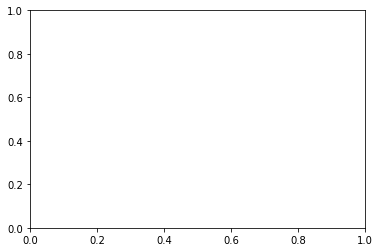

In [5]:
TronGame.view_game(game_histories[1])
TronGame.view_game(game_histories[2])
